In [30]:
from transformers import Blip2Processor
from src.models.blip2 import SurroundBlipImageProcessor
model_name = "Salesforce/blip2-opt-2.7b" 


# processor = SurroundBlipImageProcessor.from_pretrained(model_name)
processor = Blip2Processor.from_pretrained(model_name)

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

from PIL import Image
import requests
from io import BytesIO
from pathlib import Path
import pandas as pd
import numpy as np
# 장치 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 데이터셋 경로 설정
data_dir = Path("data/raw/QuIC360")

class QuIC360Dataset(Dataset):
    def __init__(self, csv_file, processor, max_length=30, split="train"):
        self.df = pd.read_csv(csv_file)
        self.processor = processor
        self.max_length = max_length
        self.split = split
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        url = row['url']
        query = row['query']
        caption = row[1]  # 두 번째 열에 캡션이 있는 것으로 가정
        
        # 이미지 다운로드 및 로드
    
        response = requests.get(url)
        image = Image.open(BytesIO(response.content)).convert('RGB')
        # print("image shape:", image.size)
        # 이미지와 텍스트 인코딩
        inputs = self.processor(
            images=image, 
            text = query,
            size = (112,224*2), # 224*2, 224*2
            do_crop=True,
            overlap_ratio=0.5,
            padding="max_length", 
            truncation=True, 
            max_length=self.max_length, 
            return_tensors="pt"
        )
        
        # 배치 차원 제거
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}
        return inputs
        
    
eval_dataset = QuIC360Dataset(data_dir/"train.csv", processor, max_length=30, split="valid")

SyntaxError: keyword argument repeated: text (1569181189.py, line 42)

In [ ]:
import matplotlib.pyplot as plt
OPENAI_CLIP_MEAN = [0.48145466, 0.4578275, 0.40821073]
OPENAI_CLIP_STD = [0.26862954, 0.26130258, 0.27577711]
loader = DataLoader(eval_dataset, batch_size=4, shuffle=False)

batch = next(iter(loader))
patches = batch["pixel_values"][0]  # 첫 번째 배치의 모든 패치, shape: [패치수, 3, 224, 224]
print("pixel_values 전체 shape:", batch["pixel_values"].shape)
print("첫 번째 배치의 patches shape:", patches.shape)
num_patches = patches.size(0)

plt.figure(figsize=(4 * num_patches, 4))

for i in range(num_patches):
    ax = plt.subplot(1, num_patches, i + 1)
    
    img = patches[i]
    img = img * torch.tensor(OPENAI_CLIP_STD).view(3, 1, 1) + torch.tensor(OPENAI_CLIP_MEAN).view(3, 1, 1)
    ax.imshow(img.permute(1, 2, 0).cpu().numpy())
    ax.set_title(f"Patch {i}")
    ax.axis("off")

plt.tight_layout()
plt.show()

큐브맵 방식으로 추출된 뷰 개수: 0
직접 perspective 변환으로 추출된 뷰 개수: 24
첫 번째 뷰 크기: (170, 170, 3)


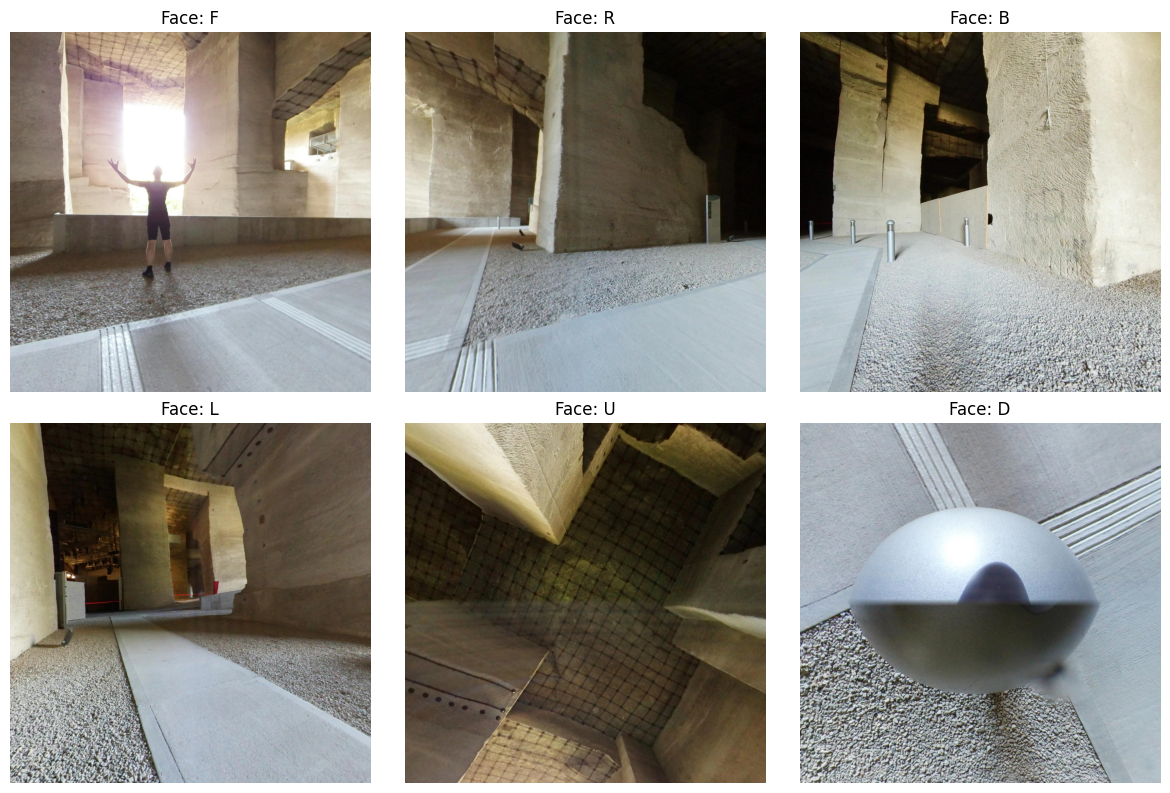

ValueError: num must be an integer with 1 <= num <= 6, not 7

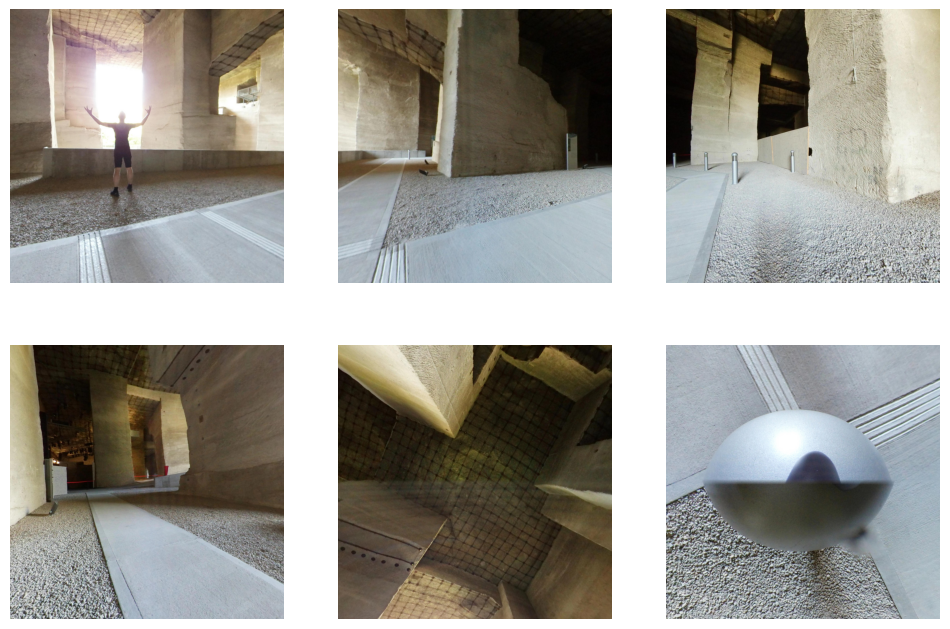

In [ ]:
import matplotlib.pyplot as plt
import requests
from io import BytesIO
from PIL import Image

import numpy as np
from py360convert import  e2c, e2p

def split_360_to_cubemap_views(equirect_img, fov=90, overlap_ratio=0.5):
    """
    360도 이미지를 큐브맵으로 변환한 후 원하는 FOV와 overlap으로 자른 이미지들을 반환
    
    Args:
        equirect_img: numpy array, 360도 이미지 (H:W = 1:2)
        fov: 시야각 (기본값 90도)
        overlap_ratio: 겹침 비율 (기본값 0.5)
    
    Returns:
        views: 잘라진 이미지들의 리스트
    """
    return 0
    # 입력 이미지 크기 확인
    h, w = equirect_img.shape[:2]
    assert w == 2 * h, "Input image must have 1:2 aspect ratio (360° image)"

url = "https://live.staticflickr.com/65535/50333141271_afd4f08f1c_o.jpg"
response = requests.get(url)
equirect_img = np.array(Image.open(BytesIO(response.content)).convert('RGB'))
overlap_ratio =0.5    
fov = 90
h, w = equirect_img.shape[:2]
# 큐브맵 한 면의 크기 결정 (정사각형에 가깝게)
face_size = h // 2

# Equirectangular -> CubeMap 변환
cubemap = e2c(equirect_img, face_w=face_size, mode='bilinear', cube_format='dict')

# FOV 90도에 맞는 출력 이미지 크기 계산
output_size = int(face_size * np.tan(np.radians(fov/2)) * 2)

# overlap 계산
overlap_pixels = int(output_size * overlap_ratio)
step_size = output_size - overlap_pixels

views = [v for v in cubemap.values()]  # 리스트 컴프리헨션 사용

# rlfb 합치기

    

# Face 시각화
plt.figure(figsize=(12, 8))
for i, face_key in enumerate(cubemap):
    ax = plt.subplot(2, 3, i + 1)
    ax.imshow(cubemap[face_key])
    ax.set_title(f"Face: {face_key}")
    ax.axis("off")
plt.tight_layout()
plt.show()

# 전체 시각화
plt.figure(figsize=(12, 8))
for i, view in enumerate(views):
    ax = plt.subplot(2, 3, i + 1)
    ax.imshow(view)
    ax.axis("off")
plt.tight_layout()
plt.show()